In [38]:
import pandas as pd
import re
import numpy as np

# Что я хочу реализовать

1. Я хочу определить патетрны на основании:

> днеавного объема торгов

> цены биткоина

> Среднеквадратичного отклонения внутри дня

> количества запросов в Google (BTC)

Аномалии снижения риска. Где можно заходить в сделку в определённом направлении и рисковать меньше чем обычно

## Информацяи из Binanse

In [39]:
def replace_num(str_):
    str_ = str(str_)
    if 'K' in str_:
        return int(str_.replace('K', '').replace(',', '')+'000')
    elif 'M' in str_:
        return int(str_.replace('M', '').replace(',', '')+'000000')
    else:
        try:
            return int(str_.replace(',', ''))
        except:
            return 0

In [40]:
# Источинк данных:
# https://ru.investing.com/crypto/bitcoin/btc-usd-historical-data?cid=1035793
df_prise_bin = pd.read_excel('parse_df_investing.xlsx') #, index_col='Дата', parse_dates=True

In [41]:
df_prise_bin.columns = [i.replace('.', '').replace(' ', '').replace('%', '') for i in list(df_prise_bin)]

In [42]:
df_prise_bin['Дата'] = pd.to_datetime(df_prise_bin['Дата'], format='%d.%m.%Y')
df_prise_bin['value_correct'] = df_prise_bin['Объём'].apply(replace_num)

<AxesSubplot:xlabel='Дата'>

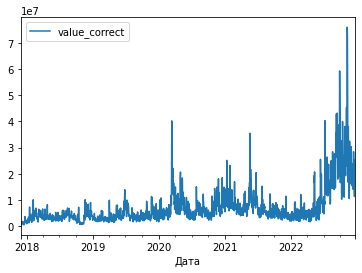

In [43]:
df_prise_bin.plot(x='Дата', y='value_correct')

<AxesSubplot:xlabel='Дата'>

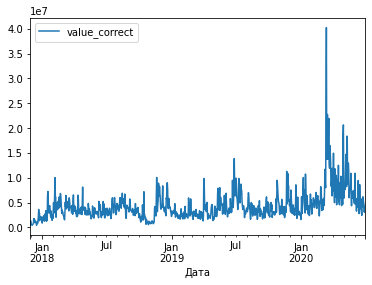

In [44]:
import datetime
d = pd.Timestamp(2020,7,1)
df_prise_bin[df_prise_bin['Дата'] < d].plot(x='Дата', y='value_correct')

In [45]:
#Чтобы не брать ситуации когда бибанс не был крупной биржей 
#буду рассматривать от 2017.12.01
#так я захвачу период максимумов в 20 000 и начну анализ с ситуации когда бинанса уже начинал становиться довольно популярной биржей. 
#популярность видно на графике выше. 

In [46]:
df_prise_bin = df_prise_bin[df_prise_bin['Дата'] >= d]

In [47]:
def num_replace(str_):
    str_ = str(str_)
    if '.' in str_ and ',' in str_:
        return float(str_.replace('.', '').replace(',', '.'))
    else: return float(str_)


for col in ['Цена', 'Откр', 'Макс', 'Мин']:
    df_prise_bin[col] = df_prise_bin[col].apply(num_replace)

<ipython-input-47-fba1ebcfcb53>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prise_bin[col] = df_prise_bin[col].apply(num_replace)


In [48]:
df_prise_bin

,Unnamed:0,Дата,Цена,Откр,Макс,Мин,Объём,Изм,value_correct
0,0,2022-12-23,16848.9,16823.1,16911.0,16771.3,"183,71K",+0.16%,18371000
1,1,2022-12-22,16821.2,16818.4,16862.0,16566.0,"176,24K",-0.07%,17624000
2,2,2022-12-21,16833.0,16896.3,16918.6,16734.8,"156,83K",-0.41%,15683000
3,3,2022-12-20,16902.7,16435.8,17031.1,16400.4,"248,79K",+2.81%,24879000
4,4,2022-12-19,16441.2,16747.9,16808.8,16333.0,"179,06K",-1.79%,17906000
...,...,...,...,...,...,...,...,...,...
901,901,2020-07-05,9084.3,9134.2,9142.1,9005.0,"34,07K",-0.59%,3407000
902,902,2020-07-04,9138.1,9053.1,9187.8,9047.8,"26,44K",+0.85%,2644000
903,903,2020-07-03,9061.4,9086.5,9122.9,9038.0,"28,94K",-0.27%,2894000
904,904,2020-07-02,9085.7,9231.4,9259.2,8959.0,"45,73K",-1.58%,4573000


In [49]:
df_prise_bin.drop(['Изм', 'Объём'], axis=1, inplace=True)

c:\Users\Kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [50]:
from sklearn.feature_selection import VarianceThreshold

In [51]:
df_prise_bin['std_day'] = df_prise_bin[['Цена', 'Откр', 'Макс', 'Мин']].std(axis=1)
df_prise_bin['mean_prise'] = df_prise_bin[['Цена', 'Откр', 'Макс', 'Мин']].mean(axis=1)
df_prise_bin['std_day_prosent'] = df_prise_bin['std_day'] / df_prise_bin['mean_prise']

<ipython-input-51-3da07e8f3bbe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prise_bin['std_day'] = df_prise_bin[['Цена', 'Откр', 'Макс', 'Мин']].std(axis=1)
<ipython-input-51-3da07e8f3bbe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prise_bin['mean_prise'] = df_prise_bin[['Цена', 'Откр', 'Макс', 'Мин']].mean(axis=1)
<ipython-input-51-3da07e8f3bbe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [52]:
df_prise_bin= df_prise_bin.sort_values('Дата')

In [53]:
df_prise_bin['roll_mean_14'] = df_prise_bin.Макс.rolling(14).mean()

Здесь нарисован график где за цену в дне стоит средняя цена между открытиме, зарытием... 

Колебаняи цены в день происходят с определённой интенсивностью, std_day_prosent, считается как стандартное отклонение/цена (процент стандартного отклонения в день) 

Пробуем узнать. Есть ли влияние этой интенсивности на дальнейшее движение цены

In [54]:
#Рисую график 

In [55]:
df_prise_bin = df_prise_bin.sort_values('Дата')

Я буду выводить как объем так и колебания не смотря на то что они сильно коррелируют ведь я ищу аномалии, если они есть хоть где-то то это может быть причиной для принятия решения.  

# Добавление moving_avg

In [56]:
df_prise_bin

,Unnamed:0,Дата,Цена,Откр,Макс,Мин,value_correct,std_day,mean_prise,std_day_prosent,roll_mean_14
905,905,2020-07-01,9232.0,9136.7,9290.4,9099.3,3849000,87.389740,9189.600,0.009510,NaN
904,904,2020-07-02,9085.7,9231.4,9259.2,8959.0,4573000,139.187604,9133.825,0.015239,NaN
903,903,2020-07-03,9061.4,9086.5,9122.9,9038.0,2894000,36.337584,9077.200,0.004003,NaN
902,902,2020-07-04,9138.1,9053.1,9187.8,9047.8,2644000,68.081667,9106.700,0.007476,NaN
901,901,2020-07-05,9084.3,9134.2,9142.1,9005.0,3407000,63.028301,9091.400,0.006933,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4,4,2022-12-19,16441.2,16747.9,16808.8,16333.0,17906000,231.505642,16582.725,0.013961,17330.114286
3,3,2022-12-20,16902.7,16435.8,17031.1,16400.4,24879000,321.481622,16692.500,0.019259,17325.128571
2,2,2022-12-21,16833.0,16896.3,16918.6,16734.8,15683000,82.330366,16845.675,0.004887,17310.214286
1,1,2022-12-22,16821.2,16818.4,16862.0,16566.0,17624000,135.407484,16766.900,0.008076,17279.342857


In [57]:
df_prise_bin.index=df_prise_bin['Дата']

In [58]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

def moving_avg(data, column, window=5, score=1.96, plot=True, ax=None, obs=True, trend=True, bounds='both', bound_param='r--'):
    
    data_mean = pd.DataFrame(index=data['Дата'], columns=['r_mean'])
    data.index = data['Дата']
#     print(data[column].rolling(window=window).mean())
    data_mean.loc[:, 'r_mean'] = data[column].rolling(window=window).mean()
#     print(data_mean)
#     data_mean.index = data_mean['Дата']
#     data_mean.drop('Дата', axis=1)
#     print(data_mean['r_mean'])
    std = np.std(data[column][window:] - data_mean['r_mean'][window:])
    
    # доверительные интервалы
    lower_bound = data_mean['r_mean'] - (score * std)
    upper_bound = data_mean['r_mean'] + (score * std)
    
    
#     print(data_mean.shape, lower_bound.shape)
    anomalies = pd.DataFrame(index=data.index, columns=['r_mean'])
    
#     print(anomalies.dtypes)
#     print(anomalies)
#     print(lower_bound)
#     print('target')
#     print(anomalies[data[column] < lower_bound].shape)
#     print(data[column][data[column] < lower_bound].shape)
#     print(anomalies[data[column] < lower_bound])
#     print(data[column][data[column] < lower_bound])
#     anomalies.loc[:, 'r_mean'][data[column] < lower_bound] = data[column][data[column] < lower_bound]
#     anomalies.loc[:, 'r_mean'][data[column] > upper_bound] = data[column][data[column] > upper_bound]


    anomalies.loc[data[column] < lower_bound, 'r_mean'] = data[column][data[column] < lower_bound]
    anomalies.loc[data[column] > upper_bound, 'r_mean'] = data[column][data[column] > upper_bound]

    
    
    
#         # ищем аномалии
#     anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
#     anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
#     anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
#     print(anomalies.loc[~anomalies.isnull()])
    
    
    if plot:
        if ax is None:        
            fig, ax = plt.subplots(figsize=(16,10))  
        if obs:
            ax.plot(data[column], label=column, color='#45678f')
        if trend:
            ax.plot(data_mean['r_mean'], 'g', label='линия тренда')
        if bounds == 'both':
#             print(upper_bound)
            ax.plot(upper_bound, bound_param, label='границы')
            ax.plot(lower_bound, bound_param)
        
        elif bounds == 'upper':
            ax.plot(upper_bound, bound_param, label='верхняя граница')
            anomalies.loc[data[column] < lower_bound, 'r_mean'] = np.nan
        ax.plot(anomalies, 'ro', markersize=7, label = 'аномалии')
#         ax.set(title='Скользящее среднее\nwindow: {}, resample: {}, score: {}'.format(window, 'по дням', score))
        ax.legend(loc='upper left', framealpha=0)
#         ax.grid()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

#     plt.show()
    
    # уведомление
#     return anomalies

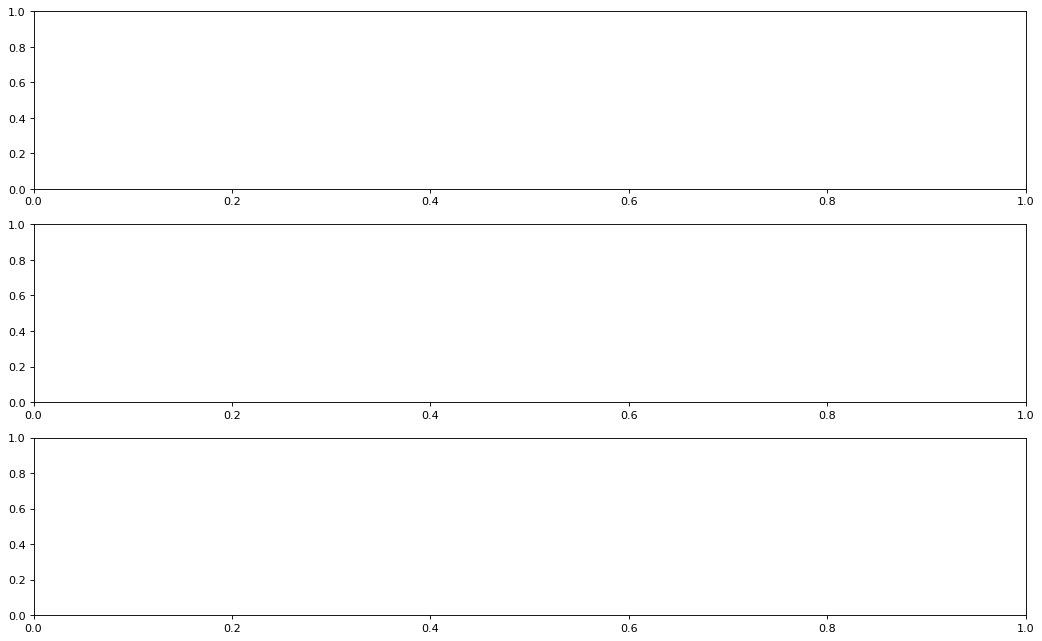

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
n_row = 3
rol_mean = 50 
fig, axes = plt.subplots(nrows=n_row, figsize=(16,10), dpi= 80)

# axes[0].plot(df_prise_bin['Дата'],df_prise_bin['mean_prise'], label='price')
# axes[0].plot(df_prise_bin['Дата'],df_prise_bin['mean_prise'].rolling(rol_mean).mean(), label=f'rolling_mean_{rol_mean}', alpha=0.6)
# moving_avg(data=df_prise_bin, column='std_day', window=21, bounds='upper', ax=axes[1])
# moving_avg(data=df_prise_bin, column='value_correct', window=21, bounds='upper', ax=axes[2])

# for i in range(n_row):
#     axes[i].grid()
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)
#     axes[i].spines['bottom'].set_visible(False)
#     axes[i].spines['left'].set_visible(False)

# # axes[0].spinse['right'].set_visible(False)
# for i in range(n_row):
#     axes[i].legend(loc='upper left')

# plt.show()

In [60]:
#По графикам видно что в последнее время сильно вырасла волатильность внутри дня. 
#для меня это скорее плохой знак т.к. напрямую говоирт о большем спекулятивном итересе. 

#Любопытно что после "очень большого" повышения волатильнсоти цена идёт по инерции в ту же сторону
#не продолжительное время. И только после этого случается коррекция

#"Это напрямую говорит мне" Что вход после аномального роста в противоположную позицию по этому актиу 
# в большенстве случает окажет плачевнй результат

In [61]:
#добавлю график запросов биткоина

In [62]:
#Просто запросы bitcoin мне не подходят. т.к. так могут писать люди для просмотра новостей. 
# Меня интересует именно прирост новой аудитории, т.е. ситуации хайпа

In [125]:
# https://trends.google.ru/trends/explore?date=2020-07-07%202022-02-07&geo=RU&q=buy%20Bitcoin

df_search = pd.read_excel('google_trand.xlsx')

In [126]:
df_search.columns = ['date_ym', 'value'] 

In [149]:
ym_min = df_search['date_ym'].iloc[0]
ym_max = df_search['date_ym'].iloc[-1]

In [154]:
date_min = pd.to_datetime(ym_min + '-01', format='%Y-%m-%d')

In [155]:
date_range = pd.date_range(start=date_min, end=df_prise_bin['Дата'].max())
df_date_range = pd.DataFrame(date_range, columns=['date'])

In [156]:
df_date_range['date_str_ym'] = df_date_range['date'].apply(lambda x: str(x)[:7])

In [170]:
df_search_evryday = df_search.merge(df_date_range, left_on='date_ym', right_on='date_str_ym')[['date', 'value']]

,date,value
0,2017-02-01,5
1,2017-02-02,5
2,2017-02-03,5
3,2017-02-04,5
4,2017-02-05,5
...,...,...
2147,2022-12-19,12
2148,2022-12-20,12
2149,2022-12-21,12
2150,2022-12-22,12


In [168]:
df_search_evryday

,date,value
0,2017-02-01,5
1,2017-02-02,5
2,2017-02-03,5
3,2017-02-04,5
4,2017-02-05,5
...,...,...
2147,2022-12-19,12
2148,2022-12-20,12
2149,2022-12-21,12
2150,2022-12-22,12


In [ ]:
df_search.index = df_search.date

In [ ]:
df_prise_bin.loc[:, 'search'] = df_search.loc[df_search['date'] >= d, 'num']

In [ ]:
df_search = df_search.loc[df_search['date'] >= d, ['num']]

In [ ]:
value_first = 94
def fillna_(num):
    global value_first
    if str(num) != 'nan':
        value_first = num
        return int(num)
    else:
        return int(value_first)
    

df_prise_bin.search = df_prise_bin.search.apply(fillna_)

In [ ]:
df_prise_bin.head()

,Дата,Цена,Откр,Макс,Мин,value_correct,std_day,mean_prise,std_day_prosent,roll_mean_14,search
Дата,,,,,,,,,,,
2020-07-01,2020-07-01,9232.0,9136.7,9290.4,9099.3,3849000,87.389740,9189.600,0.009510,NaN,94
2020-07-02,2020-07-02,9085.7,9231.4,9259.2,8959.0,4570000,139.187604,9133.825,0.015239,NaN,94
2020-07-03,2020-07-03,9061.4,9086.5,9122.9,9038.0,2897000,36.337584,9077.200,0.004003,NaN,94
2020-07-04,2020-07-04,9138.1,9053.1,9187.8,9047.8,2642000,68.081667,9106.700,0.007476,NaN,94
2020-07-05,2020-07-05,9084.3,9134.2,9142.1,9005.0,3390000,63.028301,9091.400,0.006933,NaN,94


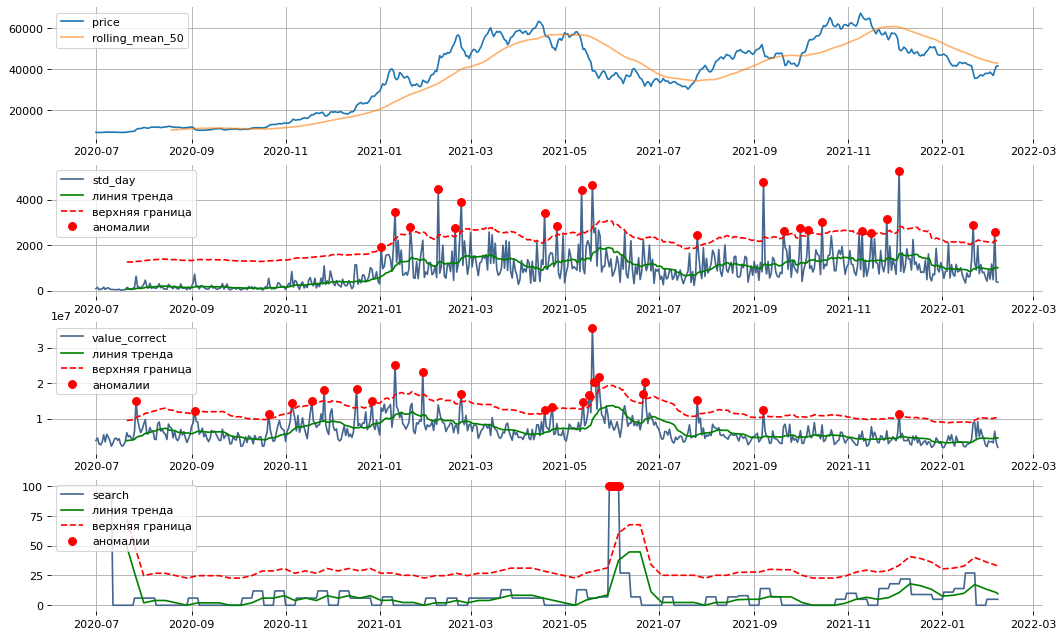

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
n_row = 4
rol_mean = 50 
fig, axes = plt.subplots(nrows=n_row, figsize=(16,10), dpi= 80)

axes[0].plot(df_prise_bin['Дата'],df_prise_bin['mean_prise'], label='price')
axes[0].plot(df_prise_bin['Дата'],df_prise_bin['mean_prise'].rolling(rol_mean).mean(), label=f'rolling_mean_{rol_mean}', alpha=0.6)
moving_avg(data=df_prise_bin, column='std_day', window=21, bounds='upper', ax=axes[1])
moving_avg(data=df_prise_bin, column='value_correct', window=21, bounds='upper', ax=axes[2])
moving_avg(data=df_prise_bin, column='search', window=21, bounds='upper', ax=axes[3])

for i in range(n_row):
    axes[i].grid()
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(False)

# axes[0].spinse['right'].set_visible(False)
for i in range(n_row):
    axes[i].legend(loc='upper left')

plt.show()

In [ ]:
# При добавлении этого графика видно. ЧТо спрос со стороны не осведомленных пользователей сильно снизился. 
# Так же интересно что падение в прошлом квартале было до уровней где покупала толпа. (уровним 2021-01)



In [ ]:
# Здесь я вижу только одну аномалию которой можно пользоваться:
# После большого среднедневного отклонениея цены в определённом направлении 
# следует продолжение движение в этом же направлении.
# Это интересно не только с точки зрения возможности входить в сделку по направлению 
# после большого скочка. А так же не входить в противовес ожидая обратного отката 
# (что является популярным заблуждением.)

# Делаю парсер

In [ ]:
# # https://ru.investing.com/crypto/bitcoin/historical-data
# df_prise = pd.read_csv('/content/Котировки криптовалюты Bitcoin - Биткоин за прошлые периоды — Investing.com.csv', sep=',')